# General Ensemble Models

The last few models we have studied have demonstrated that combining multiple models (like a *Random Forests* or *Boosting*) or otherwise building massive averaging into a model (like we did with *Neural Networks*) is a method capable of producing flexible models that are somewhat protected from overfitting. Models that are built by combining multiple models have the drawback of being harder to interpret.

In some applications, such as image recognition, interpretation is not the goal and we can easily give up interpretation in favor of models that perform better. In other applications, such as medical studies like models that are trying to predict cancer, interpretation is possibly needed because it would help inform future studies into the mechanisms and treatments of disease. On the other hand in some medical settings the goal is to build methods of automating treatment decisions and for these accuracy would be prefered over interpretation. In other applications such as studying housing data for a city, intrepretation may be the primary reason for building a model. The example I keep in mind is my work on studying student success in mathematics and science courses, while it is interesting that neural networks produce very accurate predictions of which students need additional support, they are ineffective at being used for placement of students because we cannot answer the fundamental question of *What does the student need to do to improve their placement?*

## Why do Ensemble Models Work

Today we will look at a method of building ensemble models where the individual components are independently trained models. The key feature for ensemble models is that the individual components are trained on a bootstrapped or random sample of the training data. This introduces some randomness into the ensemble model and helps avoid a full model that has responded to the irreducible error.

The method we will look at today is called *Voting* (as usual there is a Classification and a Regression version of the idea). Consider the kidney disease data set.

In [1]:
import pandas as pa
import matplotlib.pyplot as plt
import matplotlib.colors as pltco
import numpy as np
import numpy.random as rn

In [2]:
kd = pa.read_csv('Data Sets/Kidney/chronic_kidney_disease.csv', 
                 names=['age', 'bp', 'specific_gravity', 'albumin', 'sugar', 'red_blood_cells', 'pus_cell',
                        'pus_cell_clumps', 'bacteria', 'blood_glucose', 'blood_urea', 'serum_creatinine', 
                        'sodium', 'potassium', 'hemoglobin', 'packed_cell_volume', 'white_blood_cell_count',
                        'red_blood_cell_count', 'hypertension', 'diabetes_mellitus', 'coronary_artery_disease',
                        'appetite', 'pedal_edema', 'anemia', 'class'])

kd.loc[kd.loc[:, 'class'] == 'ckd\t', 'class'] = 'ckd'  # There is an extra tab character on some of the ckd values

kd.head()

,age,bp,specific_gravity,albumin,sugar,red_blood_cells,pus_cell,pus_cell_clumps,bacteria,blood_glucose,...,packed_cell_volume,white_blood_cell_count,red_blood_cell_count,hypertension,diabetes_mellitus,coronary_artery_disease,appetite,pedal_edema,anemia,class
0,48,80,1.020,1,0,?,normal,notpresent,notpresent,121,...,44,7800,5.2,yes,yes,no,good,no,no,ckd
1,7,50,1.020,4,0,?,normal,notpresent,notpresent,?,...,38,6000,?,no,no,no,good,no,no,ckd
2,62,80,1.010,2,3,normal,normal,notpresent,notpresent,423,...,31,7500,?,no,yes,no,poor,no,yes,ckd
3,48,70,1.005,4,0,normal,abnormal,present,notpresent,117,...,32,6700,3.9,yes,no,no,poor,yes,yes,ckd
4,51,80,1.010,2,0,normal,normal,notpresent,notpresent,106,...,35,7300,4.6,no,no,no,good,no,no,ckd


In [3]:
# There are some missing values for hemoglobin and blood pressure

var1 = 'hemoglobin'
var2 = 'red_blood_cell_count'

kd = kd[kd.loc[:, var1] != '?']
kd = kd[kd.loc[:, var2] != '?']
kd = kd[kd.loc[:, var2] != '\t?']
kd.loc[:, var1] = kd.loc[:, var1].astype('float')
kd.loc[:, var2] = kd.loc[:, var2].astype('float')

In [4]:
# Set our numpy array from the dataframe

X = np.array(kd[[var1, var2]])
kd['class'] = kd['class'].map({'ckd':1, 'notckd':0, 1:1, 0:0})  # Recode the result feature to be numeric; 
# note the second two values in the dictionary are in case we run this block again

y = np.array(kd[['class']]).reshape(-1)  # had to reshape it to be a vector and not a matrix

In [5]:
def plot_cat_model(clf, X, y):

    n = X.shape[0]
    test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]       # Then create the test
    y_test = y[:test]
    X_train = X[test:]     # and train sets
    y_train = y[test:]
    
    clf.fit(X_train, y_train)
    
    nn = 200 # Mesh size  
    # Plot the decision boundary. For that, we will assign a color to each
    # point in the mesh [x_min, m_max]x[y_min, y_max].
    x_min, x_max = X[:, 0].min(), X[:, 0].max()
    y_min, y_max = X[:, 1].min(), X[:, 1].max()
    xx, yy = np.meshgrid(np.linspace(x_min, x_max, nn),
        np.linspace(y_min, y_max, nn))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])

    # Put the result into a color plot
    Z = Z.reshape(xx.shape)

    plt.figure(figsize=(8, 6))
    cmap_light = pltco.ListedColormap(['#FFAAAA', '#AAFFAA'])
    cmap_bold = pltco.ListedColormap(['#FF0000', '#00FF00'])
    plt.pcolormesh(xx, yy, Z, cmap=cmap_light);

    plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cmap_bold,marker='o')
    plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test, cmap=cmap_bold, marker='+');
    
    print('Training Error: {}'.format(clf.score(X_train, y_train)))
    print('Testing Error: {}'.format(clf.score(X_test, y_test)))

In [6]:
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.ensemble import VotingClassifier

In [7]:
# We define the models that we will combine into an ensemble

clf1 = LogisticRegression(solver='lbfgs')
clf2 = LinearDiscriminantAnalysis()
clf3 = QuadraticDiscriminantAnalysis()
clf4 = SVC(C=1.0, gamma='auto', kernel='linear')
clf5 = SVC(C=1.0, gamma='auto', kernel='rbf')

The ensemble model is declared and the component models are listed. There are three important parameters, in addition to the parameters in the component models (that in this example I set above).

- *voting* is either 'hard' or 'soft'. Hard voting means that the individual models make their predictions and then the majority selects the classification (this performs best if you have an odd number of models in a two class problem). Soft voting means that the maximum predicted probability on each class determines the value.
- *weights* give different weights to each of the component models. For example we might find the model peforms best when the least flexible model is given a greater proportion of the votes.

Note that the method is parallizable, like the *Random Forest* method, i.e. each model can be computed indepdently. The parameter *n_jobs* gives the number of processors that should be dedicated to the computation and setting it to -1 means to use all available processors. 

Training Error: 0.9433962264150944
Testing Error: 0.9622641509433962


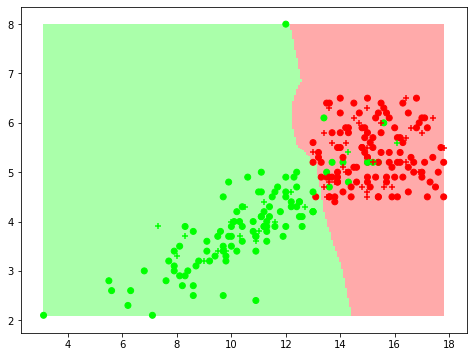

In [8]:
vclf = VotingClassifier(estimators = [ ('lr', clf1), ('lda', clf2), ('qda', clf3), ('lsvc', clf4), ('rsvc', clf5)], 
                       voting='hard', 
                       n_jobs = -1)
plot_cat_model(vclf, X, y)
plt.savefig('16.1.png')

### Baseball Player Data


In [9]:
# Read in the major league players data set

major = pa.read_csv('Data Sets/Major League Height-Weight.csv')   # creates a pandas Dataframe from a .csv file
major = major.rename({'Height(inches)':'Height', 'Weight(pounds)':'Weight'}, axis=1)  
major = major.drop(640, axis=0) 

# Each row of a data frame is a data point - in this case a player.
# Each column is a feature about the data point (its coordinates if you will)

major.head()   # displays the first few rows

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,Catcher,74,180.0,22.99
1,Paul_Bako,BAL,Catcher,74,215.0,34.69
2,Ramon_Hernandez,BAL,Catcher,72,210.0,30.78
3,Kevin_Millar,BAL,First_Baseman,72,210.0,35.43
4,Chris_Gomez,BAL,First_Baseman,73,188.0,35.71


In [10]:
# We are going to make a dictionary of key:value pairs to recode the Position feature to 
# 'Pitcher' and 'Not Pitcher'

pos_dict = {x:1 for x in list(set(major.Position)) if 'Pitcher' in x}
pos_dict2 = {x:0 for x in list(set(major.Position)) if not 'Pitcher' in x}

# Using dictionary comprehensions

pos_dict.update(pos_dict2) # merge the two dictionaries

major_2 = major.copy()   # pandas.dataframe is a mutable object so we use the .copy() command 
                         # otherwise changes to major_2 will change major
    
major_2.Position = major_2.Position.map(pos_dict)  # use the dictionary we made to recode the values with .map()

major_2

,Name,Team,Position,Height,Weight,Age
0,Adam_Donachie,BAL,0,74,180.0,22.99
1,Paul_Bako,BAL,0,74,215.0,34.69
2,Ramon_Hernandez,BAL,0,72,210.0,30.78
3,Kevin_Millar,BAL,0,72,210.0,35.43
4,Chris_Gomez,BAL,0,73,188.0,35.71
...,...,...,...,...,...,...
1029,Brad_Thompson,STL,1,73,190.0,25.08
1030,Tyler_Johnson,STL,1,74,180.0,25.73
1031,Chris_Narveson,STL,1,75,205.0,25.19
1032,Randy_Keisler,STL,1,75,190.0,31.01


In [11]:
X = np.array(major_2[['Height', 'Weight']])
y = np.array(major_2['Position'])

In [12]:
# We define the models that we will combine into an ensemble

clf1 = LogisticRegression(solver='lbfgs')
clf2 = LinearDiscriminantAnalysis()
clf3 = QuadraticDiscriminantAnalysis()
clf4 = SVC(C=1.0, gamma='auto', kernel='linear')
clf5 = SVC(C=1.0, gamma='auto', kernel='rbf')

Training Error: 0.6614268440145102
Testing Error: 0.7038834951456311


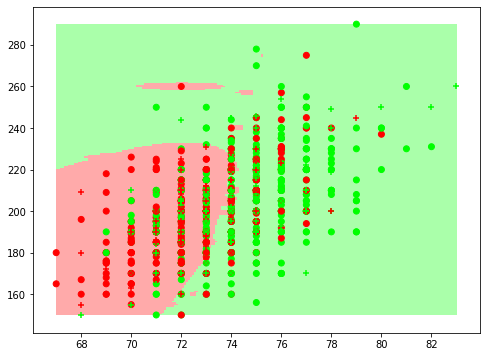

In [13]:
vclf = VotingClassifier(estimators = [ ('lr', clf1), ('lda', clf2), ('qda', clf3), ('lsvc', clf4), ('rsvc', clf5)], 
                       voting='hard', 
                       weights = [1, 1, 1.51, 1, 1.5], 
                       n_jobs = -1)
plot_cat_model(vclf, X, y)
plt.savefig('16.2.png')

One item to do here is to use the *weights* as a tuning parameter and determin the best choice for the classification.

Note that another possibility is to use a **large** collection of models like a set of SVC models with small changes to the parameter. Or collection of different K-Nearest Neighbors with different values of k. Particularly because the algorithm is paralleizable, depending on the hardware you are using, there may be only a small performance penalty for using a large number of models in your ensemble.

## Ensemble Models for Regression

Using an ensemble of models for regression is similar. Instead of voting the predict values of the result are averaged. If a *weight* parameter is provided then the weighted average is computed. Parameters passed as the same as above.

In [14]:
# Consider the following dataset about homes that sold in a city in Iowa

hd = pa.read_csv('Data Sets/house-prices/train.csv')

hd.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [15]:
def onehot(df, feature):
    '''A function to do one-hot-encoding of a feature from a dataframe. df = dataframe'''

    v = list(set(df[feature])) # Make an iterable of the unique values for the feature
    
    for c in df.index: # cycle through the samples
        t = df.loc[c, feature]
        
        for test in v:
            if pa.isna(test):  # nan values are sort of a problem and have to be handled separately
                if pa.isna(t):
                    df.loc[c, '{}_nan'.format(feature)] = 1
                else:
                    df.loc[c, '{}_nan'.format(feature)] = 0
            else:
                if t == test:
                    df.loc[c, '{}_{}'.format(feature, test)] = 1  # Makes a new feature with name feature_value
                                                              # and codes it as a 1 if that was the value
                else:
                    df.loc[c, '{}_{}'.format(feature, test)] = 0  # and 0 otherwise
            
    return df.drop(feature, axis=1) # returns a dataframe with the encoded feature removed

In [16]:
# We can recode it using a dictionary and .map()
Street_dict = {'Grvl':0, 'Pave':1, 0:0, 1:1}  
# Note we include the trivial coding of the new values as otherwise if we run this twice
# it produces NaN values for the Street feature.
hd.Street = hd.Street.map(Street_dict)
set(hd.Street)

{0, 1}

In [17]:
hd2 = onehot(hd, 'Alley')
hd3 = onehot(onehot(onehot(hd2, 'ExterQual'), 'LotShape'), 'LandContour')
hd3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Utilities,LotConfig,LandSlope,Neighborhood,...,ExterQual_TA,ExterQual_Gd,LotShape_Reg,LotShape_IR2,LotShape_IR1,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_HLS,LandContour_Low
0,1,60,RL,65.0,8450,1,AllPub,Inside,Gtl,CollgCr,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,20,RL,80.0,9600,1,AllPub,FR2,Gtl,Veenker,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,60,RL,68.0,11250,1,AllPub,Inside,Gtl,CollgCr,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,4,70,RL,60.0,9550,1,AllPub,Corner,Gtl,Crawfor,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,5,60,RL,84.0,14260,1,AllPub,FR2,Gtl,NoRidge,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [18]:
Utilities_dict = {'AllPub':1, 'NoSeWa':0, 1:1, 0:0}
hd3.Utilities = hd3.Utilities.map(Utilities_dict)
hd3.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Utilities,LotConfig,LandSlope,Neighborhood,...,ExterQual_TA,ExterQual_Gd,LotShape_Reg,LotShape_IR2,LotShape_IR1,LotShape_IR3,LandContour_Lvl,LandContour_Bnk,LandContour_HLS,LandContour_Low
0,1,60,RL,65.0,8450,1,1,Inside,Gtl,CollgCr,...,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1,2,20,RL,80.0,9600,1,1,FR2,Gtl,Veenker,...,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,3,60,RL,68.0,11250,1,1,Inside,Gtl,CollgCr,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
3,4,70,RL,60.0,9550,1,1,Corner,Gtl,Crawfor,...,1.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
4,5,60,RL,84.0,14260,1,1,FR2,Gtl,NoRidge,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [19]:
hd4 = onehot(onehot(onehot(onehot(hd3, 'LotConfig'), 'LandSlope'), 'Neighborhood'), 'MSZoning')
hd4.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,Condition1,Condition2,BldgType,HouseStyle,...,Neighborhood_Blmngtn,Neighborhood_NPkVill,Neighborhood_Blueste,Neighborhood_NAmes,Neighborhood_ClearCr,MSZoning_RH,MSZoning_FV,MSZoning_RM,MSZoning_RL,MSZoning_C (all)
0,1,60,65.0,8450,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,1,1,Feedr,Norm,1Fam,1Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
2,3,60,68.0,11250,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,60,84.0,14260,1,1,Norm,Norm,1Fam,2Story,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [20]:
def condition(df, feature1, feature2):
    
    #This is onehot encoding but for features that represent the same things 
    # - i.e. where a sample could have two values identified.
    
    v = set(list(set(df[feature1])) + list(set(df[feature2])))  # Build a list of the possible outputs
    
    for c in df.index: # cycle through the samples
        t1 = df.loc[c, feature1]
        t2 = df.loc[c, feature2]
        
        for test in v:
            if (t1==test) or (t2==test):
                df.loc[c, '{}_{}'.format(feature1, test)] = 1  # Makes a new feature with name feature_value
                                                            # and codes it as a 1 if that was the value
            else:
                df.loc[c, '{}_{}'.format(feature1, test)] = 0  # and 0 otherwise
            
    return df.drop([feature1, feature2], axis=1) # returns a dataframe with the encoded feature removed

In [21]:
hd5 = condition(hd4, 'Condition1', 'Condition2')
hd5.head()

,Id,MSSubClass,LotFrontage,LotArea,Street,Utilities,BldgType,HouseStyle,OverallQual,OverallCond,...,MSZoning_C (all),Condition1_RRAn,Condition1_RRNn,Condition1_Artery,Condition1_RRAe,Condition1_RRNe,Condition1_PosA,Condition1_PosN,Condition1_Norm,Condition1_Feedr
0,1,60,65.0,8450,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
1,2,20,80.0,9600,1,1,1Fam,1Story,6,8,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0
2,3,60,68.0,11250,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,4,70,60.0,9550,1,1,1Fam,2Story,7,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,5,60,84.0,14260,1,1,1Fam,2Story,8,5,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0


In [22]:
hd6 = onehot(onehot(onehot(onehot(hd5, 'BldgType'), 'HouseStyle'), 'RoofStyle'), 'RoofMatl')
hd6.iloc[:5, 9:]

,YearRemodAdd,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,...,RoofStyle_Flat,RoofStyle_Gambrel,RoofMatl_CompShg,RoofMatl_ClyTile,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_WdShngl,RoofMatl_Tar&Grv,RoofMatl_Membran,RoofMatl_WdShake
0,2003,VinylSd,VinylSd,BrkFace,196.0,TA,PConc,Gd,TA,No,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,1976,MetalSd,MetalSd,None,0.0,TA,CBlock,Gd,TA,Gd,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2002,VinylSd,VinylSd,BrkFace,162.0,TA,PConc,Gd,TA,Mn,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1970,Wd Sdng,Wd Shng,None,0.0,TA,BrkTil,TA,Gd,No,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2000,VinylSd,VinylSd,BrkFace,350.0,TA,PConc,Gd,TA,Av,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [23]:
# Probably enough, lets make a list of all of the features that are not 'object'
# (i.e. that are numerical)

keep = hd6.columns[hd6.dtypes!='object'][1:]
keep

Index(['MSSubClass', 'LotFrontage', 'LotArea', 'Street', 'Utilities',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea',
       ...
       'RoofStyle_Flat', 'RoofStyle_Gambrel', 'RoofMatl_CompShg',
       'RoofMatl_ClyTile', 'RoofMatl_Metal', 'RoofMatl_Roll',
       'RoofMatl_WdShngl', 'RoofMatl_Tar&Grv', 'RoofMatl_Membran',
       'RoofMatl_WdShake'],
      dtype='object', length=128)

In [24]:
# Check for NaN

for v in keep:
    if sum(np.isnan(hd6[v]))!=0:
        print(v)

LotFrontage
MasVnrArea
GarageYrBlt


In [25]:
# MasVnrArea and GarageYrBlt that are NaN probably mean 0 (i.e. no Garage and no Masonry)

for k in hd6.index:
    if np.isnan(hd6.loc[k, 'MasVnrArea']):
        hd6.loc[k, 'MasVnrArea']=0
    if np.isnan(hd6.loc[k, 'GarageYrBlt']):
        hd6.loc[k, 'GarageYrBlt']=0


In [26]:
keep = list(hd6.columns[hd6.dtypes!='object'][1:])
keep.remove('LotFrontage')   # There are some NaNs in LotFrontage. We could try to fill them in with a regression.
                             # Or we might check with a content expert and see if they should be 0
hd7 = hd6.loc[:, keep]
hd7.head()

,MSSubClass,LotArea,Street,Utilities,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,RoofStyle_Flat,RoofStyle_Gambrel,RoofMatl_CompShg,RoofMatl_ClyTile,RoofMatl_Metal,RoofMatl_Roll,RoofMatl_WdShngl,RoofMatl_Tar&Grv,RoofMatl_Membran,RoofMatl_WdShake
0,60,8450,1,1,7,5,2003,2003,196.0,706,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,20,9600,1,1,6,8,1976,1976,0.0,978,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,60,11250,1,1,7,5,2001,2002,162.0,486,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,70,9550,1,1,7,5,1915,1970,0.0,216,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,60,14260,1,1,8,5,2000,2000,350.0,655,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [27]:
# Convert them to Numpy Arrays X for predictors and y for result

keep.remove('SalePrice')
X = np.array(hd7.loc[:, keep])
y = np.array(hd7.loc[:, 'SalePrice'])

In [28]:
def check_model(reg, X, y):

    n = X.shape[0]
    test = int(0.20*n)            # We will use a test set made up of 20% of the data from our sample
    perm = rn.permutation(n)   
    X = X[perm]
    y = y[perm]
    X_test = X[:test]       # Then create the test
    y_test = y[:test]
    X_train = X[test:]     # and train sets
    y_train = y[test:]
    
    reg.fit(X_train, y_train)
    
    print('Training R2: {}'.format(reg.score(X_train, y_train)))
    print('Testing R2: {}'.format(reg.score(X_test, y_test)))

Check performance on a few of our basic models.

In [29]:
from sklearn.linear_model import Ridge
ridge_reg = Ridge(alpha=30)
check_model(ridge_reg, X, y)

Training R2: 0.866595091171879
Testing R2: 0.8030096758616679


In [30]:
from sklearn.linear_model import Lasso
lasso_reg = Lasso(alpha=325)
check_model(lasso_reg, X, y)

Training R2: 0.8970630788100761
Testing R2: 0.5412395691741727


In [31]:
from sklearn.neighbors import KNeighborsRegressor
knn_reg = KNeighborsRegressor(n_neighbors = 12)
check_model(knn_reg, X, y)

Training R2: 0.6897735810955243
Testing R2: 0.6836703471993115


In [32]:
from sklearn.tree import DecisionTreeRegressor
tree_reg = DecisionTreeRegressor(min_samples_leaf = 30)
check_model(tree_reg, X, y)

Training R2: 0.8052144539166817
Testing R2: 0.7287898725059567


Now using these trees in a voting ensemble.

In [33]:
from sklearn.ensemble import VotingRegressor

In [34]:
reg = VotingRegressor([('ridge', ridge_reg), ('lasso', lasso_reg), ('knn', knn_reg), ('tree', tree_reg)], 
                     weights = [1, 1, 1, 1], 
                     n_jobs = -1)
check_model(reg, X, y)

Training R2: 0.8810683599933237
Testing R2: 0.6591639972871473


Introducing the scikit-learn builtin cross validation method:

In [35]:
from sklearn.model_selection import cross_val_score
ridge_scores = cross_val_score(ridge_reg, X, y, cv=10)
lasso_scores = cross_val_score(lasso_reg, X, y, cv=10)
voting_scores = cross_val_score(reg, X, y, cv=10)

In [36]:
print('Ridge Mean R2: {}'.format(ridge_scores.mean()))
print('Ridge Standard Deviation R2: {}'.format(ridge_scores.std()))

Ridge Mean R2: 0.8351922637021216
Ridge Standard Deviation R2: 0.09489032846771378


In [37]:
print('Lasso Mean R2: {}'.format(lasso_scores.mean()))
print('Lasso Standard Deviation R2: {}'.format(lasso_scores.std()))

Lasso Mean R2: 0.8295175043295793
Lasso Standard Deviation R2: 0.10198600028930702


In [38]:
print('Voting Mean R2: {}'.format(voting_scores.mean()))
print('Voting Standard Deviation R2: {}'.format(voting_scores.std()))

Voting Mean R2: 0.8387630724803878
Voting Standard Deviation R2: 0.06437616120378123


Provided the component models are not too much worse than the best one, we expect voting to produce more consistent results even if not better.

## Parameter Grid Search

Now is a good time to demonstrate one of the builtin features from scikit-learn we have not used yet. There is a built in method for searching a grid worth of parameter space to find the best values. Let's use it to search for the correct weights.

This is an example where parrallelization will really pay off and in fact if we were doing this for production it might be worth brining some heavy iron to the problem for effenciently and carefully exploring the parameter space. More on how you might actually do this in practice next week.

In [39]:
from sklearn.model_selection import GridSearchCV
ww = np.linspace(0.1, 10, 6)
weight_space = [ [k1, k2, k3, k4] for k1 in ww for k2 in ww for k3 in ww for k4 in ww]
parameters = {'weights':weight_space}
reg = VotingRegressor([('ridge', ridge_reg), ('lasso', lasso_reg), ('knn', knn_reg), ('tree', tree_reg)],  
                     n_jobs = -1)
reg_grd = GridSearchCV(reg, parameters, cv=5, n_jobs=-1).fit(X, y)

In [40]:
print('Maximum Cross Validated Mean Score: {}'.format(reg_grd.cv_results_['mean_test_score'].max()))
print('Occurs for weights: {}'.format(reg_grd.cv_results_['params'][reg_grd.cv_results_['mean_test_score'].argmax()]['weights']))

Maximum Cross Validated Mean Score: 0.8392940041183417
Occurs for weights: [10.0, 2.08, 2.08, 4.06]
